# import libraries

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import plotly.express as px
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
import shap
from lime.lime_tabular import LimeTabularExplainer
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score


import warnings
warnings.filterwarnings("ignore")

# Read the data

In [2]:
data = pd.read_csv('Loan.csv')

In [3]:
data.head()

,ApplicationDate,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2018-01-01,45,39948,617,Employed,Master,22,13152,48,Married,...,3329.000000,0.724972,11,126928,0.199652,0.227590,419.805992,0.181077,0,49.0
1,2018-01-02,38,39709,628,Employed,Associate,15,26045,48,Single,...,3309.083333,0.935132,3,43609,0.207045,0.201077,794.054238,0.389852,0,52.0
2,2018-01-03,47,40724,570,Employed,Bachelor,26,17627,36,Married,...,3393.666667,0.872241,6,5205,0.217627,0.212548,666.406688,0.462157,0,52.0
3,2018-01-04,58,69084,545,Employed,High School,34,37898,96,Single,...,5757.000000,0.896155,5,99452,0.300398,0.300911,1047.506980,0.313098,0,54.0
4,2018-01-05,37,103264,594,Employed,Associate,17,9184,36,Married,...,8605.333333,0.941369,5,227019,0.197184,0.175990,330.179140,0.070210,1,36.0


In [4]:
data.shape

(20000, 36)

In [5]:
data.drop(columns=['ApplicationDate', 'RiskScore'], inplace=True)

In [6]:
data.shape

(20000, 34)

## Data Preprocessing

In [7]:
numerical_features = [
    'Age', 
    'AnnualIncome', 
    'CreditScore',
    'Experience',
    'LoanAmount',
    'LoanDuration',
    'NumberOfDependents',
    'MonthlyDebtPayments',
    'CreditCardUtilizationRate',
    'NumberOfOpenCreditLines',
    'NumberOfCreditInquiries',
    'DebtToIncomeRatio',
    'BankruptcyHistory',
    'PreviousLoanDefaults',
    'PaymentHistory',
    'LengthOfCreditHistory',
    'SavingsAccountBalance',
    'CheckingAccountBalance',
    'TotalAssets',
    'TotalLiabilities',
    'MonthlyIncome',
    'UtilityBillsPaymentHistory',
    'JobTenure',
    'NetWorth',
    'BaseInterestRate',
    'InterestRate',
    'MonthlyLoanPayment',
    'TotalDebtToIncomeRatio'
]
print(f'Number of numerical features: {len(numerical_features)}')

Number of numerical features: 28


In [8]:
categorical_features = [
    'EmploymentStatus',
    'MaritalStatus',
    'HomeOwnershipStatus',
    'LoanPurpose'
]
print(f'Number of categorical features: {len(categorical_features)}')

Number of categorical features: 4


In [9]:
ordinal_features = [
    'EducationLevel'
]

print(f'Number of ordinal features: {len(ordinal_features)}')

Number of ordinal features: 1


In [ ]:
for feature in categorical_features + ordinal_features:
    print(f"cardinality of {feature}: {data[feature].nunique()}")

Cardinality of EmploymentStatus: 3
Cardinality of MaritalStatus: 4
Cardinality of HomeOwnershipStatus: 4
Cardinality of LoanPurpose: 5
Cardinality of EducationLevel: 5


In [11]:
X = data.drop(columns='LoanApproved')
y = data['LoanApproved']

In [12]:
X.head()

,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,...,TotalAssets,TotalLiabilities,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio
0,45,39948,617,Employed,Master,22,13152,48,Married,2,...,146111,19183,3329.000000,0.724972,11,126928,0.199652,0.227590,419.805992,0.181077
1,38,39709,628,Employed,Associate,15,26045,48,Single,1,...,53204,9595,3309.083333,0.935132,3,43609,0.207045,0.201077,794.054238,0.389852
2,47,40724,570,Employed,Bachelor,26,17627,36,Married,2,...,25176,128874,3393.666667,0.872241,6,5205,0.217627,0.212548,666.406688,0.462157
3,58,69084,545,Employed,High School,34,37898,96,Single,1,...,104822,5370,5757.000000,0.896155,5,99452,0.300398,0.300911,1047.506980,0.313098
4,37,103264,594,Employed,Associate,17,9184,36,Married,1,...,244305,17286,8605.333333,0.941369,5,227019,0.197184,0.175990,330.179140,0.070210


In [13]:
X.shape

(20000, 33)

In [14]:
y.shape

(20000,)

In [15]:
def remove_highly_correlated_features(df, threshold=0.9):
    corr_matrix = df.corr()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column].abs() > threshold)]
    return df.drop(columns=to_drop), to_drop

In [16]:
X_numerical, dropped_features = remove_highly_correlated_features(X[numerical_features])
print(f"Dropped highly correlated features: {dropped_features}")

Dropped highly correlated features: ['Experience', 'MonthlyIncome', 'NetWorth']


In [17]:
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

oridnal_pipeline = Pipeline([
    ('ordinal', OrdinalEncoder())
])

In [18]:
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, X_numerical.columns),
    ('cat', categorical_pipeline, categorical_features),
    ('ord', oridnal_pipeline, ordinal_features)
])

In [19]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Fitting the Classifier using GridSearch Cross Validation

In [37]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(random_state=42))
])

In [38]:
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__learning_rate': [0.01, 0.1, 1.0]
}

In [39]:
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

In [40]:
grid_search.fit(X_dev, y_dev)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/opt/homebrew/anaconda3/envs/aml-project/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/homebrew/anaconda3/envs/aml-project/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/homebrew/anaconda3/envs/aml-project/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/homebrew/anaconda3/envs/aml-project/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

[CV] END classifier__learning_rate=0.01, classifier__n_estimators=50; total time=   1.5s
[CV] END classifier__learning_rate=0.01, classifier__n_estimators=50; total time=   1.5s
[CV] END classifier__learning_rate=0.01, classifier__n_estimators=50; total time=   1.6s
[CV] END classifier__learning_rate=0.01, classifier__n_estimators=50; total time=   1.6s
[CV] END classifier__learning_rate=0.01, classifier__n_estimators=50; total time=   1.6s


/opt/homebrew/anaconda3/envs/aml-project/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/homebrew/anaconda3/envs/aml-project/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/homebrew/anaconda3/envs/aml-project/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/homebrew/anaconda3/envs/aml-project/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

[CV] END classifier__learning_rate=0.01, classifier__n_estimators=100; total time=   3.0s
[CV] END classifier__learning_rate=0.01, classifier__n_estimators=100; total time=   3.1s
[CV] END classifier__learning_rate=0.01, classifier__n_estimators=100; total time=   3.1s
[CV] END classifier__learning_rate=0.1, classifier__n_estimators=50; total time=   1.6s
[CV] END classifier__learning_rate=0.01, classifier__n_estimators=100; total time=   3.1s
[CV] END classifier__learning_rate=0.01, classifier__n_estimators=100; total time=   3.2s


/opt/homebrew/anaconda3/envs/aml-project/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/homebrew/anaconda3/envs/aml-project/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/homebrew/anaconda3/envs/aml-project/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/homebrew/anaconda3/envs/aml-project/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

[CV] END classifier__learning_rate=0.1, classifier__n_estimators=50; total time=   1.6s
[CV] END classifier__learning_rate=0.1, classifier__n_estimators=50; total time=   1.6s
[CV] END classifier__learning_rate=0.1, classifier__n_estimators=50; total time=   1.6s
[CV] END classifier__learning_rate=0.1, classifier__n_estimators=50; total time=   1.6s


/opt/homebrew/anaconda3/envs/aml-project/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/homebrew/anaconda3/envs/aml-project/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/homebrew/anaconda3/envs/aml-project/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/homebrew/anaconda3/envs/aml-project/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

[CV] END classifier__learning_rate=0.01, classifier__n_estimators=200; total time=   6.1s
[CV] END classifier__learning_rate=0.1, classifier__n_estimators=100; total time=   3.0s
[CV] END classifier__learning_rate=0.1, classifier__n_estimators=100; total time=   3.0s


/opt/homebrew/anaconda3/envs/aml-project/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/homebrew/anaconda3/envs/aml-project/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/homebrew/anaconda3/envs/aml-project/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END classifier__learning_rate=0.01, classifier__n_estimators=200; total time=   6.1s
[CV] END classifier__learning_rate=0.01, classifier__n_estimators=200; total time=   6.2s
[CV] END classifier__learning_rate=0.01, classifier__n_estimators=200; total time=   6.2s
[CV] END classifier__learning_rate=0.1, classifier__n_estimators=100; total time=   3.0s
[CV] END classifier__learning_rate=0.1, classifier__n_estimators=100; total time=   3.0s
[CV] END classifier__learning_rate=0.01, classifier__n_estimators=200; total time=   6.2s
[CV] END classifier__learning_rate=0.1, classifier__n_estimators=100; total time=   3.1s


/opt/homebrew/anaconda3/envs/aml-project/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/homebrew/anaconda3/envs/aml-project/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/homebrew/anaconda3/envs/aml-project/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/homebrew/anaconda3/envs/aml-project/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

[CV] END classifier__learning_rate=1.0, classifier__n_estimators=50; total time=   1.6s
[CV] END classifier__learning_rate=1.0, classifier__n_estimators=50; total time=   1.5s
[CV] END classifier__learning_rate=1.0, classifier__n_estimators=50; total time=   1.6s
[CV] END classifier__learning_rate=1.0, classifier__n_estimators=50; total time=   1.6s
[CV] END classifier__learning_rate=1.0, classifier__n_estimators=50; total time=   1.6s


/opt/homebrew/anaconda3/envs/aml-project/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/homebrew/anaconda3/envs/aml-project/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/homebrew/anaconda3/envs/aml-project/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/homebrew/anaconda3/envs/aml-project/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated a

[CV] END classifier__learning_rate=0.1, classifier__n_estimators=200; total time=   6.1s
[CV] END classifier__learning_rate=1.0, classifier__n_estimators=100; total time=   3.1s


/opt/homebrew/anaconda3/envs/aml-project/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/homebrew/anaconda3/envs/aml-project/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END classifier__learning_rate=0.1, classifier__n_estimators=200; total time=   6.1s
[CV] END classifier__learning_rate=0.1, classifier__n_estimators=200; total time=   6.2s
[CV] END classifier__learning_rate=1.0, classifier__n_estimators=100; total time=   3.1s
[CV] END classifier__learning_rate=1.0, classifier__n_estimators=100; total time=   3.1s
[CV] END classifier__learning_rate=1.0, classifier__n_estimators=100; total time=   3.2s
[CV] END classifier__learning_rate=1.0, classifier__n_estimators=100; total time=   3.2s
[CV] END classifier__learning_rate=0.1, classifier__n_estimators=200; total time=   6.3s


/opt/homebrew/anaconda3/envs/aml-project/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/homebrew/anaconda3/envs/aml-project/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END classifier__learning_rate=0.1, classifier__n_estimators=200; total time=   5.9s
[CV] END classifier__learning_rate=1.0, classifier__n_estimators=200; total time=   5.4s
[CV] END classifier__learning_rate=1.0, classifier__n_estimators=200; total time=   4.9s
[CV] END classifier__learning_rate=1.0, classifier__n_estimators=200; total time=   5.0s
[CV] END classifier__learning_rate=1.0, classifier__n_estimators=200; total time=   4.3s
[CV] END classifier__learning_rate=1.0, classifier__n_estimators=200; total time=   4.4s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration',
       'NumberOfDependents', 'MonthlyDebtPayments',
       'CreditCardUtilizationRate', 'NumberOfOpenCreditLines',
       'NumberOfCreditInquiries', 'DebtToIncom...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['EmploymentStatus',
                                                                          'MaritalStatus',
                                                                          'HomeOwnershipStatus',
                                                                          'LoanPurpose']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('ordinal',
                                                                                          OrdinalEncoder())]),
                                                                         ['EducationLevel'])])),
                                       ('classifier',
                                        AdaBoostClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.01, 0.1, 1.0],
                         'classifier__n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=2)

In [41]:
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.2f}")

Best Parameters: {'classifier__learning_rate': 1.0, 'classifier__n_estimators': 200}
Best Cross-Validation Accuracy: 0.96


## Evaluation

In [42]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [62]:
print("\nTest Set Performance:")
print(classification_report(y_test, y_pred))


Test Set Performance:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3044
           1       0.93      0.92      0.93       956

    accuracy                           0.97      4000
   macro avg       0.95      0.95      0.95      4000
weighted avg       0.97      0.97      0.97      4000



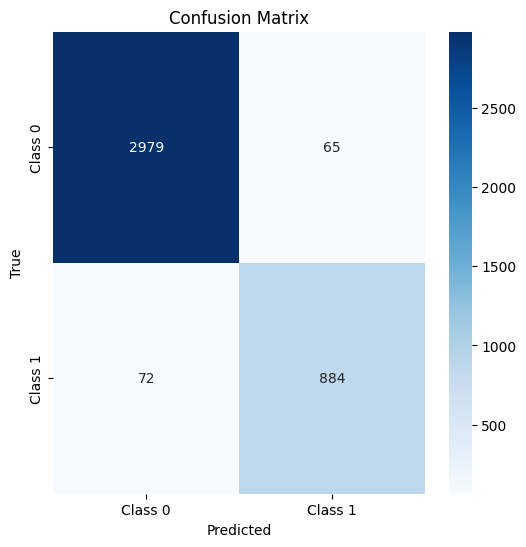

In [ ]:
y_pred = best_model.predict(X_test) 
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

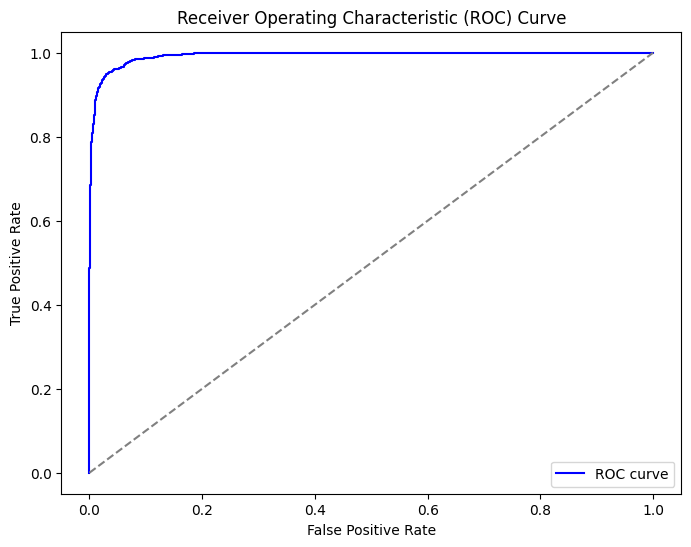

In [ ]:
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
auroc = roc_auc_score(y_test, y_pred_proba)
print(f"AUROC: {auroc}")

AUROC: 0.9935767735692411


## Model Interpretability

In [47]:
def get_feature_names():
    transformed_feature_names = []
    transformed_feature_names.extend(numerical_features)

    categorical_features = preprocessor.transformers_[1][2]  # Categorical features list
    cat_feature_names = preprocessor.transformers_[1][1].get_feature_names_out(categorical_features)
    transformed_feature_names.extend(cat_feature_names)

    ordinal_features = preprocessor.transformers_[2][2]  # Ordinal features list
    transformed_feature_names.extend(ordinal_features)

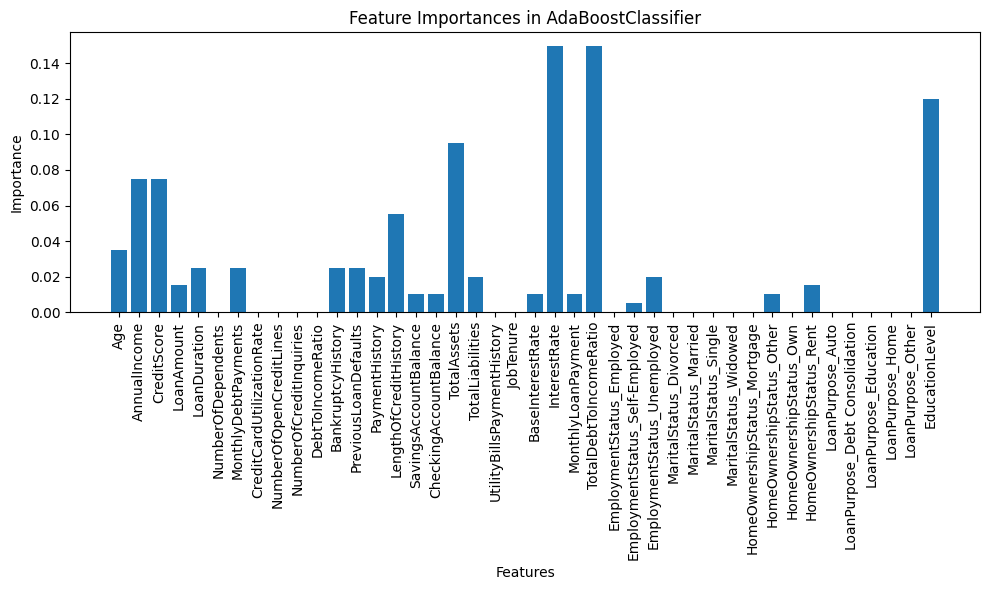

In [45]:
model = best_model.named_steps['classifier']

feature_importances = model.feature_importances_

preprocessor = best_model.named_steps['preprocessor']

numerical_features = X_numerical.columns

transformed_feature_names = []
transformed_feature_names.extend(numerical_features)

categorical_features = preprocessor.transformers_[1][2]  # Categorical features list
cat_feature_names = preprocessor.transformers_[1][1].get_feature_names_out(categorical_features)
transformed_feature_names.extend(cat_feature_names)

ordinal_features = preprocessor.transformers_[2][2]  # Ordinal features list
transformed_feature_names.extend(ordinal_features)

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances, align="center")
plt.xticks(range(len(feature_importances)), transformed_feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances in AdaBoostClassifier')
plt.tight_layout()

plt.show()

PermutationExplainer explainer: 4001it [22:26,  2.97it/s]                            


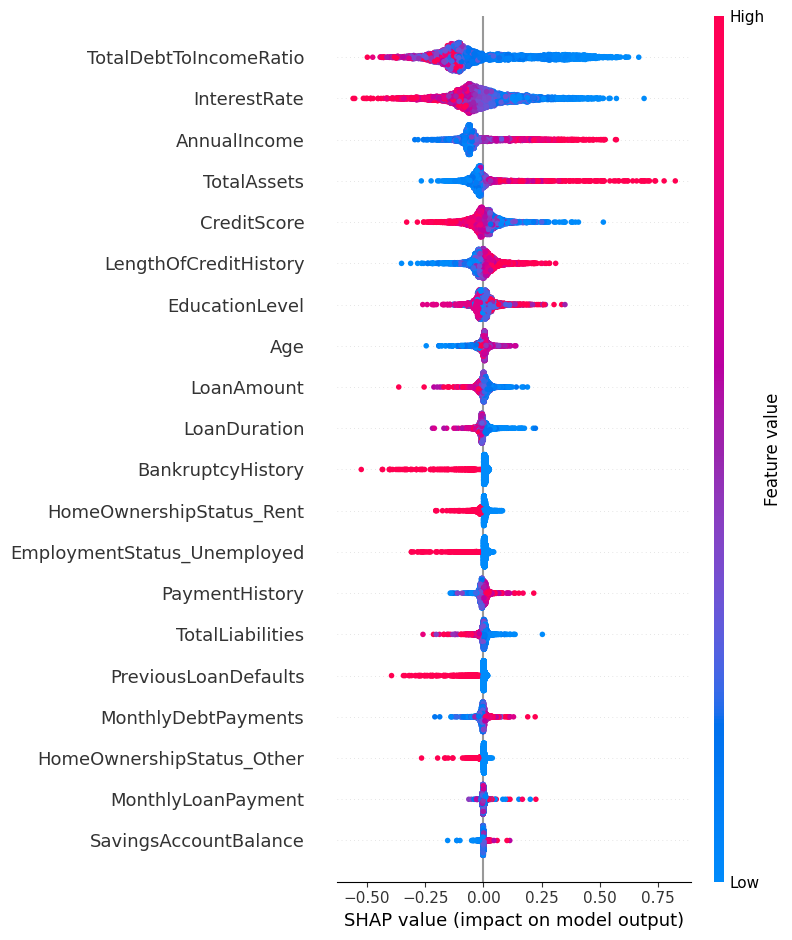

In [ ]:
# Apply the preprocessor transformation to X_dev and X_test to ensure numerical format
X_dev_transformed = best_model.named_steps['preprocessor'].transform(X_dev)
X_test_transformed = best_model.named_steps['preprocessor'].transform(X_test)

# Create the explainer using the AdaBoostClassifier's prediction function
explainer = shap.Explainer(model.predict, X_dev_transformed)

# Calculate SHAP values for the transformed test set
shap_values = explainer(X_test_transformed)

# Plot the SHAP summary
shap.summary_plot(shap_values, X_test_transformed, feature_names=transformed_feature_names)

In [ ]:
# plot the first weak learner
tree = model.estimators_[0]  
dot_data = export_graphviz(tree, feature_names=get_feature_names(), filled=True, rounded=True)
graph = Source(dot_data)
graph.render("adaboost_first_tree")

'adaboost_first_tree.pdf'

In [58]:
X_dev_transformed = best_model.named_steps['preprocessor'].transform(X_dev)
X_test_transformed = best_model.named_steps['preprocessor'].transform(X_test)

explainer = LimeTabularExplainer(
    X_dev_transformed,
    training_labels=y_dev,
    feature_names=get_feature_names(),
    class_names=["0", "1"],
    mode="classification"
)

instance = X_test_transformed[0].reshape(1, -1) 
explanation = explainer.explain_instance(
    instance.flatten(),
    model.predict_proba  
)

explanation.show_in_notebook(show_table=True)
explanation.save_to_file("lime_explanation_adaboost.html")